# Feed-forward Neural Network

In diesem Notebook schauen wir uns Neuronale Netze an.
In der Praxis verwendet man für Bilddaten üblicherweise Convolutional Neural Networks (CNNs); diese haben wir im Theorie Teil aber nicht im Detail angeschaut.
Daher verwenden wir hier Feed-forward Neural Networks mit einem Hidden Layer.

Das Neuronale Netz ist in `tensorflow` programmiert.

In [1]:
!pip install tensorflow==2.6

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, activations, Sequential, losses
from tensorflow.keras.regularizers import L2

import pickle

import pandas as pd

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [6]:
def plot_confusion_matrix(y_true: any, y_pred: any):
    labels = np.unique(y_true)
    fig = plt.figure(figsize=(len(labels), len(labels)))
    ConfusionMatrixDisplay(
      confusion_matrix=confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels, normalize='all'),
      display_labels=labels
    ).plot(ax=fig.gca(), cmap="BuPu", xticks_rotation='vertical', include_values=True)
    plt.show()

# Daten vorbereiten

In [7]:
# Daten laden und aufteilen in Features und Labels
with open('../data/train.pkl', 'rb') as f:
    data_train = pickle.load(f)
X_data = data_train["images"]
y_data = data_train["labels"]

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=42)

##### Preprocessing

Für tensorflow müssen wir die Text-Labels (wie `frog`) in Zahlen umwandeln. Dazu verwenden wir den `LabelEncoder`.

Die Daten werden hier mittels `tf.image.per_image_standardization` standardisiert.

In [9]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

In [10]:
# tf.image.per_image_standardization ist ein übliches Preprocessing für Bilddaten.
X_train_std = tf.image.per_image_standardization(X_train).numpy()
X_val_std = tf.image.per_image_standardization(X_val).numpy()

#### NN (0 hidden layer -> Logistic Regression)

Zuerst bauen wir die `Logistic Regression` als Neural Network nach.

![Logistic Regression als Neural Network](./img/logistic_regression_as_nn.png)

Die Performanz sollte ähnlich sein zu unserer `Logistic Regression` Baseline.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output_layer (Dense)         (None, 10)                30730     
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
293/293 [==============================] - 2s 5ms/step - loss: 2.1487 - accuracy: 0.3198 - val_loss: 2.0146 - val_accuracy: 0.3547
Epoch 2/40
293/293 [==============================] - 1s 3ms/step - loss: 1.9723 - accuracy: 0.3717 - val_loss: 1.9551 - val_accuracy: 0.3674
Epoch 3/40
293/293 [==============================] - 1s 3ms/step - loss: 1.9104 - accuracy: 0.3874 - val_loss: 1.9262 - val_accuracy: 0.3817
Epoch 4/40
293/293 [==============================] - 1s 3ms/step - loss: 1.8740 - accuracy: 0.3971 - val_loss: 1.9022 - val_accuracy: 0.3902
Epoch 5/40
293/293 [==============================] - 1s 4ms/step - loss:

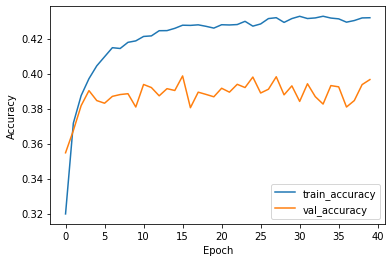

0.39656


In [11]:
lr = Sequential([
    layers.InputLayer(input_shape=(32*32*3), name='input_layer'),
    layers.Dense(10, activation=activations.linear, kernel_regularizer=L2(), name='output_layer'),
])
lr.compile(
    optimizer='sgd',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(lr.summary())

history = lr.fit(X_train_std.reshape(-1, 32 * 32 * 3), y_train_enc, batch_size=128, epochs=40, validation_data=(X_val_std.reshape(-1, 32 * 32 * 3), y_val_enc))
plot_history(history)

y_val_hat_prob = lr.predict(X_val_std.reshape(-1, 32 * 32 * 3))
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val_enc))

#### NN (1 hidden layer) no Regularization

Nun fügen wir einen `Hidden Layer` hinzu.

![Neural Network mit einem Hidden Layer](./img/one_hidden_nn.png)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 1024)              3146752   
_________________________________________________________________
output_layer (Dense)         (None, 10)                10250     
Total params: 3,157,002
Trainable params: 3,157,002
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
293/293 [==============================] - 9s 29ms/step - loss: 1.8051 - accuracy: 0.3636 - val_loss: 1.6363 - val_accuracy: 0.4260
Epoch 2/40
293/293 [==============================] - 8s 28ms/step - loss: 1.5299 - accuracy: 0.4662 - val_loss: 1.5542 - val_accuracy: 0.4531
Epoch 3/40
293/293 [==============================] - 8s 26ms/step - loss: 1.4171 - accuracy: 0.5103 - val_loss: 1.5260 - val_accuracy: 0.4626
Epoch 4/40
293/293 [==============================] - 8s 27ms/step - los

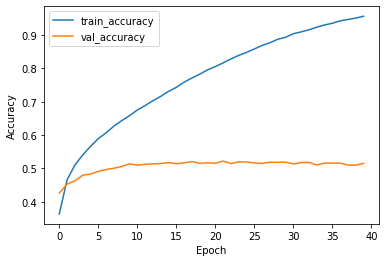

0.51528


In [12]:
nn = Sequential([
    layers.InputLayer(input_shape=(32*32*3), name='input_layer'),
    layers.Dense(1024, activation=activations.relu, name='hidden_layer'),
    layers.Dense(10, activation=activations.linear, name='output_layer'),
])
nn.compile(
    optimizer='sgd',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(nn.summary())

history = nn.fit(X_train_std.reshape(-1, 32 * 32 * 3), y_train_enc, batch_size=128, epochs=40, validation_data=(X_val_std.reshape(-1, 32 * 32 * 3), y_val_enc))
plot_history(history)

y_val_hat_prob = nn.predict(X_val_std.reshape(-1, 32 * 32 * 3))
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val_enc))

#### NN (1 hidden layer) with L2 Regularization

Nun fügen wir L2 Regularisierung hinzu, um gegen das Overfitting zu helfen.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 1024)              3146752   
_________________________________________________________________
output_layer (Dense)         (None, 10)                10250     
Total params: 3,157,002
Trainable params: 3,157,002
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
293/293 [==============================] - 12s 40ms/step - loss: 16.4665 - accuracy: 0.3726 - val_loss: 15.4679 - val_accuracy: 0.4222
Epoch 2/40
293/293 [==============================] - 11s 38ms/step - loss: 14.5862 - accuracy: 0.4681 - val_loss: 13.8646 - val_accuracy: 0.4506
Epoch 3/40
293/293 [==============================] - 11s 37ms/step - loss: 13.0613 - accuracy: 0.5064 - val_loss: 12.4744 - val_accuracy: 0.4702
Epoch 4/40
293/293 [==============================] - 12s 41ms/

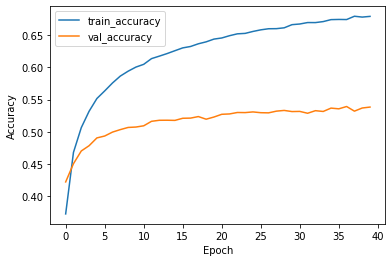

0.53832


In [13]:
nn_l2 = Sequential([
    layers.InputLayer(input_shape=(32*32*3), name='input_layer'),
    layers.Dense(1024, activation=activations.relu, kernel_regularizer=L2(0.01), name='hidden_layer'),
    layers.Dense(10, activation=activations.linear, kernel_regularizer=L2(0.01), name='output_layer'),
])
nn_l2.compile(
    optimizer='sgd',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(nn_l2.summary())

history = nn_l2.fit(X_train_std.reshape(-1, 32 * 32 * 3), y_train_enc, batch_size=128, epochs=40, validation_data=(X_val_std.reshape(-1, 32 * 32 * 3), y_val_enc))
plot_history(history)

y_val_hat_prob = nn_l2.predict(X_val_std.reshape(-1, 32 * 32 * 3))
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val_enc))

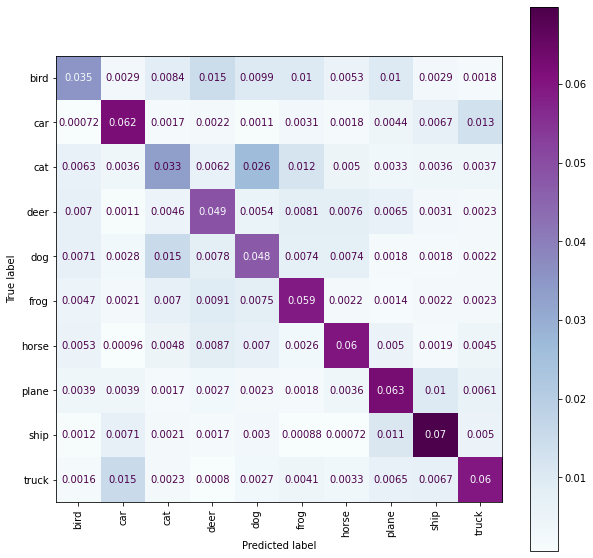

In [14]:
plot_confusion_matrix(
    y_true=y_val,
    y_pred=le.inverse_transform(y_val_hat)
)

# Anwendung des Modells auf dem Test Set

Wenn wir mit der Leistung unseres Modells auf dem `Validation Set` zufrieden sind, können wir es auf das `Test Set` anwenden.

In [15]:
with open('../data/test.pkl', 'rb') as f:
    X_test = pickle.load(f)

In [16]:
y_test_pred_prob = nn_l2.predict(X_test.reshape(-1, 32 * 32 * 3))
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
y_test_pred_enc = le.inverse_transform(y_test_pred)
y_test_pred_df = pd.DataFrame(y_test_pred_enc, columns=['label'])

Um die Vorhersagen an Kaggle zu senden, schreiben wir sie in eine .csv-Datei, die Sie manuell übermitteln können.

In [17]:
y_test_pred_df.to_csv('../out/neural_network.csv', header=True, index_label='id')